In [120]:
import nibabel as nib
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
from nilearn.image import resample_to_img
from nilearn.image import resample_img

from loguru import logger
import pandas as pd

In [188]:
class NiftiManager:
    def __init__(self) -> None:
        pass

    def load_nifti(self, file_path):
        '''Loads the NIfTI image and access the image data as a Numpy array.'''
        nii_image = nib.load(file_path)
        data_array = nii_image.get_fdata()

        return data_array, nii_image

    def show_nifti(self, file_data, title, slice=25):
        '''Displays a single slice from the nifti volume (change the slice index as needed).'''
        plt.imshow(file_data[:, :, slice], cmap='gray')
        plt.title(title)
        plt.colorbar()
        plt.show()

    def show_label_seg_nifti(self, label, seg, subject_id, slice=25):
        '''Displays both segmentation and ground truth labels as passed to the function.'''
        plt.figure(figsize=(20, 7))
        
        plt.subplot(1, 2, 1)
        plt.imshow(label[:, :, slice], cmap='gray') 
        plt.title(f'Label Image (Subject ID={subject_id})')
        plt.colorbar()

        plt.subplot(1, 2, 2)
        plt.imshow(seg[:, :, slice], cmap='gray') 
        plt.title(f'Segmentation Image (Subject ID={subject_id})')
        plt.colorbar()
        plt.show()

    def normalize_nifti(self, volume):
        '''Performs Min-Max scaling normalization on nifti volumes.'''
        # Calculate the minimum and maximum values of the volume
        min_val = np.min(volume)
        max_val = np.max(volume)

        # Perform min-max scaling normalization
        normalized_volume = (volume - min_val) / (max_val - min_val)

        return normalized_volume

    def show_mean_volumes(self, mean_csf, mean_wm, mean_gm, slice=128):
        '''Displays the mean volumes for CSF, WM, and GM.'''
        plt.figure(figsize=(20, 7))

        plt.subplot(1, 3, 1)
        plt.imshow(mean_csf[:, :, slice], cmap='gray')
        plt.title('Mean CSF Volume')
        plt.colorbar()

        plt.subplot(1, 3, 2)
        plt.imshow(mean_wm[:, :, slice], cmap='gray')
        plt.title('Mean WM Volume')
        plt.colorbar()

        plt.subplot(1, 3, 3)
        plt.imshow(mean_gm[:, :, slice], cmap='gray')
        plt.title('Mean GM Volume')
        plt.colorbar()

        plt.show()

    def show_combined_mean_volumes(self, mean_csf, mean_wm, mean_gm, slice_to_display=128):
        # Stack the mean volumes along the fourth axis to create a single 4D array
        combined_mean_volumes = np.stack((mean_csf, mean_wm, mean_gm), axis=3)
    
        # Choose the channel you want to display (0 for CSF, 1 for WM, 2 for GM)
        channel_to_display = 0  # Adjust as needed
    
        # Display the selected channel
        plt.imshow(combined_mean_volumes[:, :, :, :][:, :, slice_to_display]) # [:, :, :, channel_to_display]
        plt.axis('off')  # Turn off axis labels
        plt.title(f'Mean Volume of Slice {slice_to_display}')  # Add a title
        plt.show()


NM = NiftiManager()

In [180]:
labels_output_path = 'output/labels'

results_volumes = sorted(glob(os.path.join(labels_output_path, "**", "result.nii"), recursive=True))
results_volumes

['output/labels\\1001\\result.nii',
 'output/labels\\1002\\result.nii',
 'output/labels\\1006\\result.nii',
 'output/labels\\1007\\result.nii',
 'output/labels\\1008\\result.nii',
 'output/labels\\1009\\result.nii']

In [181]:
print("total labels volumes: ", len(results_volumes))
print("Expected max pixel value: ", (3*len(results_volumes)) / len(results_volumes))
print("Expected min pixel value: ", (0*len(results_volumes)) / len(results_volumes))

total labels volumes:  6
Expected max pixel value:  3.0
Expected min pixel value:  0.0


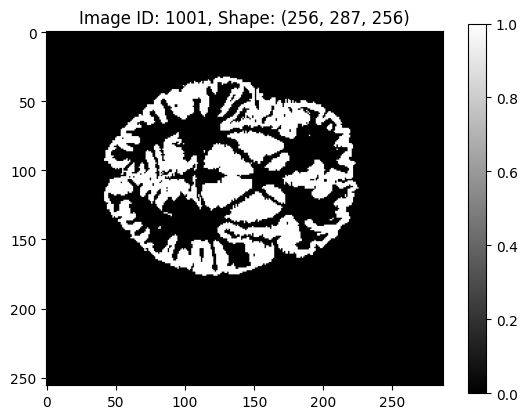

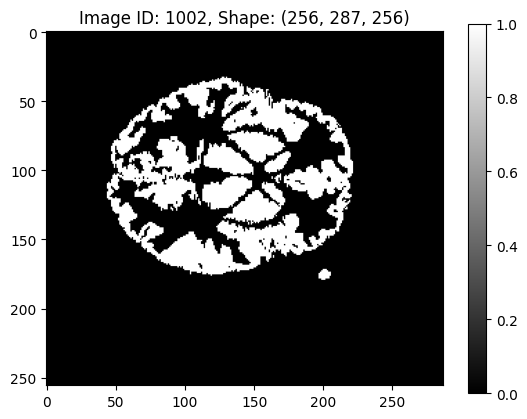

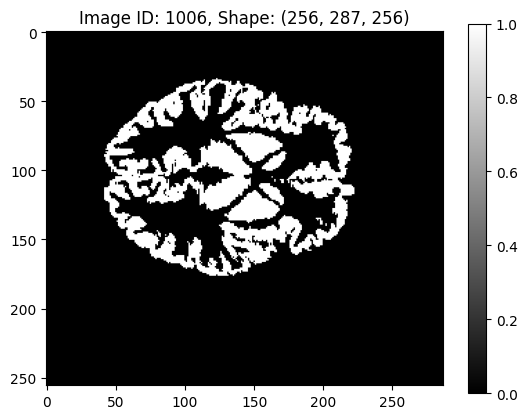

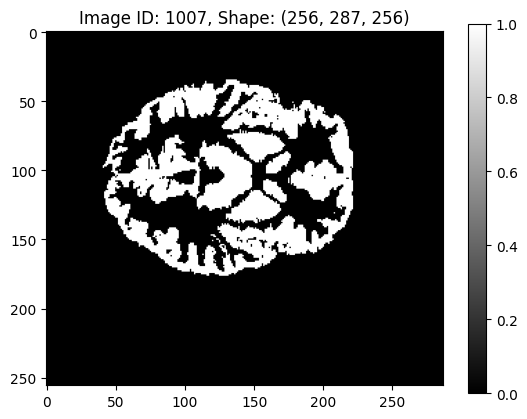

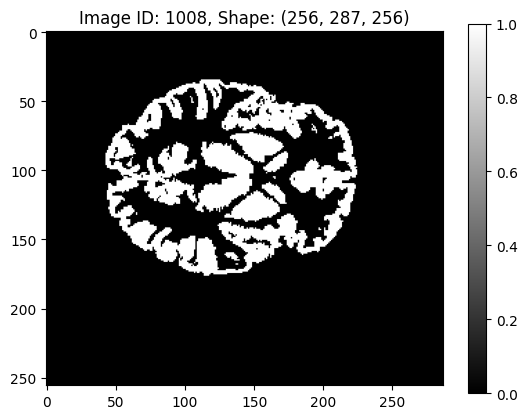

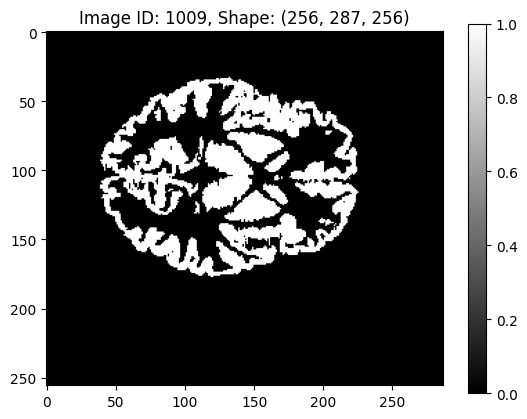

In [182]:
vol_nifti_csf_list = [] # 1
vol_nifti_wm_list   = [] # 2
vol_nifti_gm_list   = [] # 3

for volume in results_volumes:
    vol_nifti, _ = NM.load_nifti(volume)

    # display WM tissue
    vol_nifti_csf = vol_nifti == 1
    vol_nifti_wm  = vol_nifti == 2
    vol_nifti_gm  = vol_nifti == 3

    vol_nifti_csf_list.append(vol_nifti_csf)
    vol_nifti_wm_list.append(vol_nifti_wm)
    vol_nifti_gm_list.append(vol_nifti_gm)
    
    NM.show_nifti(vol_nifti_gm, title="Image ID: " + volume.split('\\')[-2] + f", Shape: {vol_nifti.shape}", slice=128)

In [183]:
# Calculate the mean volumes
mean_csf = np.mean(vol_nifti_csf_list, axis=0)
mean_wm = np.mean(vol_nifti_wm_list, axis=0)
mean_gm = np.mean(vol_nifti_gm_list, axis=0)

In [184]:
# checking the unique values of one of the means (max has to be 1)
unique_values_csf, counts = np.unique(mean_csf, return_counts=True)
print("unique_values_csf: ", unique_values_csf)
print("counts: ", counts)

unique_values_csf:  [0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.        ]
counts:  [18771717    13037     5410     3965     3200     3617     7886]


In [185]:
print(mean_csf.shape)
print(mean_csf.dtype)

(256, 287, 256)
float64


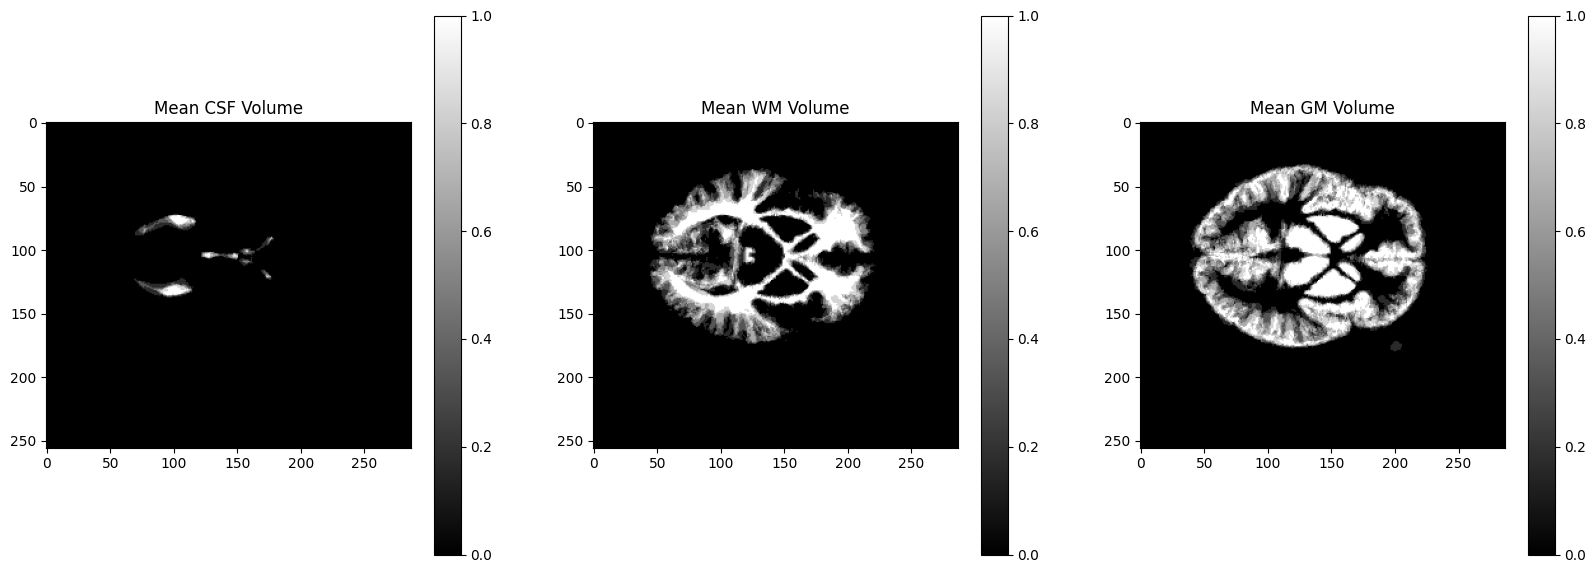

In [186]:
NM.show_mean_volumes(mean_csf, mean_wm, mean_gm, slice=128)

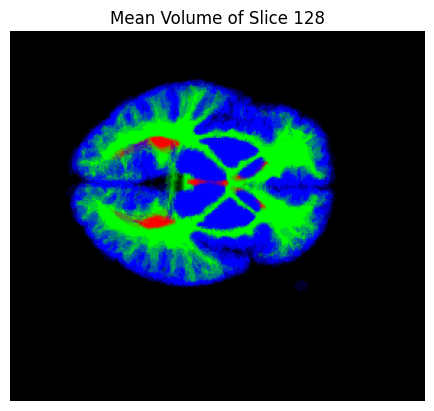

In [189]:
# Show combined probabilities as rgb
NM.show_combined_mean_volumes(mean_csf, mean_wm, mean_gm, slice_to_display=128)

#### Obtaining the mean intensity images on the same labels used now

In [191]:
images_output_path = 'output/images'

intensities_volumes = sorted(glob(os.path.join(images_output_path, "**", "result.1.nii"), recursive=True))
intensities_volumes

['output/images\\1001\\result.1.nii',
 'output/images\\1002\\result.1.nii',
 'output/images\\1006\\result.1.nii',
 'output/images\\1007\\result.1.nii',
 'output/images\\1008\\result.1.nii',
 'output/images\\1009\\result.1.nii']

In [192]:
images_reference_path = 'training-set/training-images/1000.nii.gz'
intensities_volumes.insert(0, images_reference_path)
intensities_volumes

['training-set/training-images/1000.nii.gz',
 'output/images\\1001\\result.1.nii',
 'output/images\\1002\\result.1.nii',
 'output/images\\1006\\result.1.nii',
 'output/images\\1007\\result.1.nii',
 'output/images\\1008\\result.1.nii',
 'output/images\\1009\\result.1.nii']

In [194]:
vol_nifti_intensities = []

for volume_path in intensities_volumes:
    vol_nifti, _ = NM.load_nifti(volume_path)    
    vol_nifti_intensities.append(vol_nifti)

In [195]:
len(vol_nifti_intensities)

7

In [196]:
mean_intensity = np.mean(vol_nifti_intensities, axis=0)

In [199]:
mean_intensity.shape

(256, 287, 256)

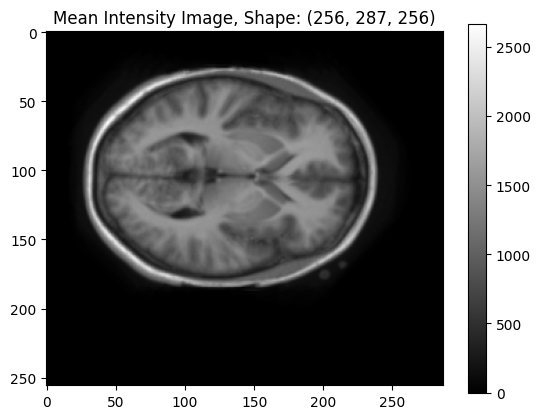

In [200]:
NM.show_nifti(mean_intensity, title=f"Mean Intensity Image, Shape: {mean_intensity.shape}", slice=128)

#### Plotting the histograms

In [128]:
# dropping again the reference image
intensities_volumes.pop(0)
intensities_volumes 

# TODO: ASK, do we need to include the reference volume also in both tissue map and probability volume? 

['output/labels\\1001\\result.nii',
 'output/labels\\1002\\result.nii',
 'output/labels\\1006\\result.nii',
 'output/labels\\1007\\result.nii',
 'output/labels\\1008\\result.nii',
 'output/labels\\1009\\result.nii']

In [227]:
vol_nifti_csf_intensity = [] # 1
vol_nifti_gm_intensity  = [] # 2
vol_nifti_wm_intensity  = [] # 3

for volume, intensity in zip(results_volumes, intensities_volumes[1:]):
    vol_nifti, _ = NM.load_nifti(volume)
    int_nifti, _ = NM.load_nifti(intensity)    

    # select WM tissue
    csf_nifti =  vol_nifti == 1
    wm_nifti  =  vol_nifti == 2
    gm_nifti  =  vol_nifti == 3

    csf_volume = int_nifti * csf_nifti
    wm_volume  = int_nifti * wm_nifti
    gm_volume  = int_nifti * gm_nifti

    vol_nifti_csf_intensity.append(csf_volume)
    vol_nifti_wm_intensity.append(wm_volume)
    vol_nifti_gm_intensity.append(gm_volume)

    # print(gm_volume.shape)
    # NM.show_label_seg_nifti(vol_nifti_wm, int_nifti, subject_id=1, slice=128)

vol_nifti_csf_intensity = np.array(vol_nifti_csf_intensity)
vol_nifti_wm_intensity  = np.array(vol_nifti_wm_intensity)
vol_nifti_gm_intensity  = np.array(vol_nifti_gm_intensity)

In [228]:
print(vol_nifti_csf_intensity.shape)

(6, 256, 287, 256)


In [229]:
print(np.max(vol_nifti_csf_intensity[0]))

1290.5146484375


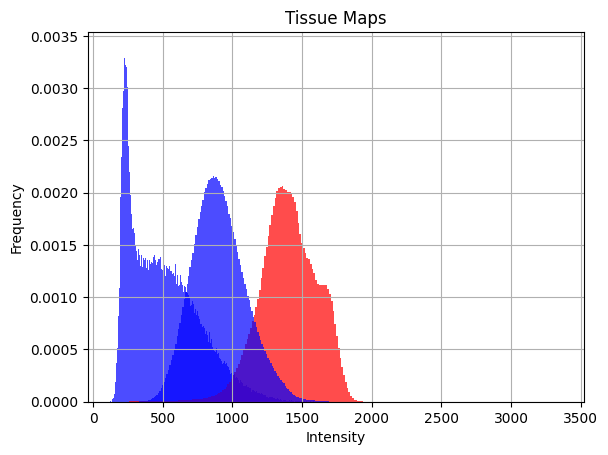

In [232]:
# Create a histogram with 100 bins
# Histogram matching to the template image
# normalise the intensity images

vol_nifti_csf_intensity = vol_nifti_csf_intensity[vol_nifti_csf_intensity != 0]
vol_nifti_wm_intensity  = vol_nifti_wm_intensity[vol_nifti_wm_intensity != 0]
vol_nifti_gm_intensity  = vol_nifti_gm_intensity[vol_nifti_gm_intensity != 0]

plt.hist(vol_nifti_csf_intensity, bins=256, color='blue', alpha=0.7, density=True)
plt.hist(vol_nifti_wm_intensity, bins=256, color='red', alpha=0.7, density=True)
plt.hist(vol_nifti_gm_intensity, bins=256, color='blue', alpha=0.7, density=True)

plt.title('Tissue Maps')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.grid()
plt.show()
